In [1]:
%load_ext autoreload
%autoreload 2
import sys
if "../../../" not in sys.path:
    sys.path.append("../../../")

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass

from volterra_hawkes.kernel.kernels import *
from volterra_hawkes.iVi.iVi_hawkes import IVIHawkesProcess
from volterra_hawkes.iVi.iVi import IVIVolterra

plt.style.use('seaborn-v0_8-deep')
plt.style.use('default')  # 'default' or any other light theme like 'seaborn-white'

color_cycle = ["#B56246", "#579F40", "#9A46B5", "#4699B5", "#B54662", "#D4A017", "#5b6c64", "#71074E", "#0033A0"]
plt.rcParams["figure.figsize"]        = ((1 + np.sqrt(5)) / 2 * 5, 5)
plt.rcParams["figure.autolayout"]     = True
plt.rcParams["patch.force_edgecolor"] = False
plt.rcParams["axes.grid"]             = True
plt.rcParams['axes.prop_cycle']       = matplotlib.cycler(color=color_cycle)

In [ ]:
H = 0.5
eps = 0.1
T = 200

In [251]:
K_limit = FractionalKernel(H=H)

In [252]:
n_steps = 1000
n_paths = 1
t_grid = np.linspace(0, 1, n_steps + 1)

rng = np.random.default_rng(seed=42)
ivi_volterra = IVIVolterra(is_continuous=True, resolvent_flag=False, kernel=K_limit,
                           g0_bar=K_limit.double_integrated_kernel, rng=rng, b=1, c=1)

U_lim, Z_lim = ivi_volterra.simulate_u_z(t_grid=t_grid, n_paths=n_paths)

In [253]:
### Hawkes process simulation
T_arr = [10, 100, 200, 500, 1000, 5000]
N_arr = []
U_arr = []
for T in T_arr:
    @dataclass
    class CustomKernel(Kernel):
        H: float
        eps: float
        T: float

        def __post_init__(self):
            self.c = (self.eps / self.T)**(self.H + 0.5) * (self.H + 0.5) * (1 - self.T**(-self.H-0.5))

        def __call__(self, t):
            t = np.array(t)
            valid_mask = t >= 0  # Avoid issues with negative values
            result = np.zeros_like(t, dtype=np.float64)
            result[valid_mask] = self.c / (t[valid_mask] + self.eps / self.T)**(self.H + 1.5)
            return result

        def integrated_kernel(self, t):
            t = np.array(t)
            valid_mask = t >= 0  # Avoid issues with negative values
            result = np.zeros_like(t, dtype=np.float64)
            result[valid_mask] = self.c / (self.H + 0.5) * ((self.eps / self.T)**(-self.H - 0.5) -
                                                            (t[valid_mask] + self.eps / self.T)**(-self.H - 0.5))
            return result

        def double_integrated_kernel(self, t):
            raise NotImplementedError

        @property
        def resolvent(self) -> Kernel:
            raise NotImplementedError

        def inv_integrated_kernel(self, x):
            raise NotImplementedError

        def inv_kernel(self, x):
            raise NotImplementedError

        def inv_double_integrated_kernel(self, x):
            raise NotImplementedError

    mu_T = T**(H + 0.5)

    def g0_T(t, mu=mu_T):
        return mu * np.ones_like(t)

    def g0_bar_T(t, mu=mu_T):
        return mu * t

    K_T = CustomKernel(T=T, eps=eps, H=H)

    rng = np.random.default_rng(seed=42)
    ivi_hawkes = IVIHawkesProcess(kernel=K_T, g0_bar=g0_bar_T, rng=rng, g0=g0_T, resolvent_flag=False)
    N_T, U_T, _ = ivi_hawkes.simulate_on_grid(t_grid=t_grid, n_paths=n_paths)
    N_arr.append(N_T)
    U_arr.append(U_T)

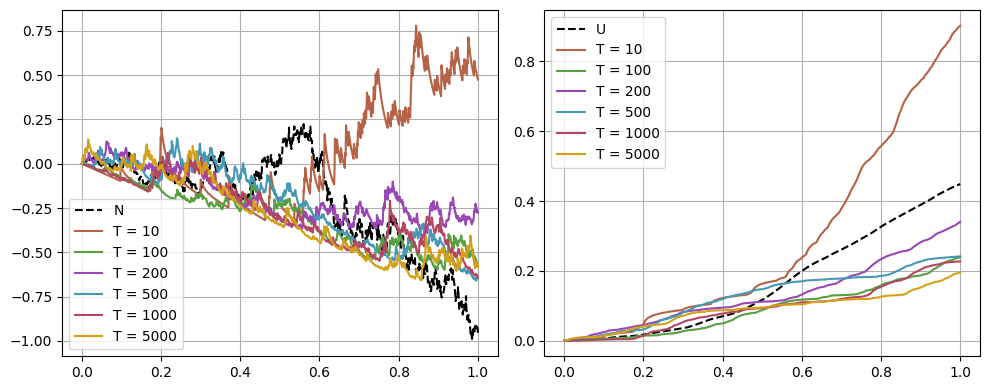

In [256]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(t_grid, Z_lim, "--", label="N", color="k")
ax[1].plot(t_grid, U_lim, "--", label="U", color="k")

for T, N_T, U_T in zip(T_arr, N_arr, U_arr):
    ax[0].plot(t_grid, (N_T - U_T) * T**(H + 0.5) / T**(1 + 2*H), label=f"T = {T}")
    ax[1].plot(t_grid, U_T / T**(1 + 2*H), label=f"T = {T}")

ax[0].legend()
ax[1].legend()
plt.show()